In [1]:
# import needed modules
import os
import matplotlib.pyplot as plt   #needed for plotting
import matplotlib.dates as mdates #needed for formating axis
from datetime import datetime     #needed for string to datetime
import re                         #needed for stripping excess characters from strings
import time                       #for performance checking - okay to cut if all calls to it are removed
from collections import Counter

In [2]:
tic = time.perf_counter() # start a timer

In [3]:
#path to open logs from - needs to change per use case
path = 'C:/Users/ncurtis/Desktop/New'

In [4]:
#this reads in all the files in the folder
#this means that ONLY log files can be in the target folder or the program will error
# the files open in alphabetical order so the format is log.1, log.10, log.11 ... log.9
    #the important take away is that the lines are NOT in chronological order, so care must be taken when finding first and last entries
#this is also the slowest part of the program, taking ~2/3 of total run time

matrix = []  #create an empty matrix to store files
for filename in os.listdir(path): #iterate over all files in the folder
    with open(os.path.join(path, filename)) as log_file: #open each file as read only
        matrix += [line.split() for line in log_file] #append the files to the matrix
        #creating a new list at each newline character in the log

In [5]:
print("Import done") #debug check
toc1 = time.perf_counter() # time check
print(round(toc1 - tic,3), "seconds")

Import done
4.768 seconds


In [6]:
#trimmer function, to extract only needed lines for each matrix
#this makes the resulting matrices much smaller and faster to process
#requires two arguments: output and target
#output is the array where the filtered data will be stored
#target is the string that is used to filter the original matrix

def trimmer(output, target):
    output += list(filter(lambda x: target in x, matrix))
    return;

In [7]:
#create seperate matrices for each data source needed later
pm0_trimmed_matrix =[]            #contains PM0 input data
pm4_trimmed_matrix = []           #contains PM4 input data
pf = []                           #contains PM0 and PM4 output data
faults = []                       #contians fault codes
trimmer(pm0_trimmed_matrix, "PM0") 
trimmer(pm4_trimmed_matrix, "PM4")
trimmer(pf, "power")
trimmer(faults,"smart_pwr_fault_and_cntl_info_handler:")

In [8]:
print("Trimmed matrix complete") #debug check
toc2 = time.perf_counter() #time check
print(round(toc2 - tic,3), "seconds")

Trimmed matrix complete
6.023 seconds


In [9]:
# create empty matricies for voltage and current
# columns are "Date","Time","Tag","Service","Fetch","PM","Input","Voltages","VinA","VinB","VinC" for voltages
# columns are "Date","Time","Tag","Service","Fetch","PM","Input","Voltages","IinA","IinB","IinC" for currents

pm0_voltage_matrix = [] 
pm0_current_matrix = []
pm4_voltage_matrix = [] 
pm4_current_matrix = [] 

In [10]:
# create empty matricies for power factor
# columns are "Date","Time","Tag","Service","PM#","factor,"energy","p amps","p volts","t amps","t volts" for currents
pf_0 = [] #PM0
pf_4 = [] #PM4

In [11]:
#filter to create new matricies for just voltages and currents
#sub-filtering allows for easier graphing and manipulation
pm0_voltage_matrix = list(filter(lambda x: "Voltages:" in x, pm0_trimmed_matrix))
pm0_current_matrix = list(filter(lambda x: "Currents:" in x, pm0_trimmed_matrix))
pm4_voltage_matrix = list(filter(lambda x: "Voltages:" in x, pm4_trimmed_matrix))
pm4_current_matrix = list(filter(lambda x: "Currents:" in x, pm4_trimmed_matrix))
pf_0 = list(filter(lambda x: "PM#0" in x, pf))
pf_4 = list(filter(lambda x: "PM#4" in x, pf))

In [12]:
# time and debug check
toc3 = time.perf_counter()
print("Voltage and Current matricies complete")
print(round(toc3 - tic,3) , "seconds")

Voltage and Current matricies complete
6.078 seconds


In [13]:
#This functiion is used to strip out letters so data can be turned into floats or datetimes
#It takes two arguements:
#A source matrix to be stripped
#An output matrix to store the stripped data


# need to make this much more efficient

non_decimal = re.compile(r'[\.\-\:\d]+') # compile a regular expression of chars to be stripped
#\. keeps "." characters to maintain decimal place,
#\- keeps "-" characters to maintain both sign and date format
#\: keeps ":" characters to maintain date format
#\d keeps numeric characters 0-9
def stripper(source, output):
    for i in source:
        lst = []                             # this is to preserve the format of the original matrix
        for j in i:
            lst+= re.findall(non_decimal,j)  #run the regular expression over each element in a line and add the result to the
        output.append(lst)                   #append the row to the matrix
    return;

In [14]:
#use the stripper function on the various matrices

pm0_v_m_strip = []
pm0_c_m_strip = []
pm4_v_m_strip = []
pm4_c_m_strip = []
#pm0_out_strip = []
#pm4_out_strip = []
pf_0_strip = []
pf_4_strip = []

In [15]:
stripper(pm0_voltage_matrix, pm0_v_m_strip)
stripper(pm0_current_matrix, pm0_c_m_strip)
stripper(pm4_voltage_matrix, pm4_v_m_strip)
stripper(pm4_current_matrix, pm4_c_m_strip)
stripper(pf_0, pf_0_strip)
stripper(pf_4, pf_4_strip)

In [16]:
# time and debug check
print("Stripping complete")
toc4 = time.perf_counter()
print(round(toc4 - tic,3), "seconds")

Stripping complete
6.437 seconds


In [17]:
#This function is used to format the data into a new matrix for ease of handling and graphing
#Notably, it drops columns that I don't need to graph and transposes the ones being kept to play nicely with matplotlib
#It takes two arguements:
#A source matrix to be formatted
#An output matrix to store the formatted data


def formatter(source, output):
    output = [[0]*len(source) for i in range(4)]
    #arrange the output matrix so it has the right form: four rows with as many columns as there are entries to be added
    for i in range (0, len(source)): # iterate over the source
        output[0][i] = (datetime.strptime((source[i][0] +" "+ source[i][1]) , "%Y-%m-%d %H:%M:%S.%f"))
        #Convert string to datetime type. First concantenate the date and time strings, then provide strptime arguements
        output[1][i] = (float(source[i][6]))
        output[2][i] = (float(source[i][7]))
        output[3][i] = (float(source[i][8]))
        #float and write the data strings
    return output; #return the output matrix, assign this to output at end

In [18]:
#use formatter to prepare for graphing
pm0_v_m_graph = []
pm0_c_m_graph = []
pm4_v_m_graph = []
pm4_c_m_graph = []
pm0_v_m_graph = formatter(pm0_v_m_strip,pm0_v_m_graph)
pm0_c_m_graph = formatter(pm0_c_m_strip,pm0_c_m_graph)
pm4_v_m_graph = formatter(pm0_v_m_strip,pm0_v_m_graph)
pm4_c_m_graph = formatter(pm0_c_m_strip,pm0_c_m_graph)

In [19]:
#this is the same formatter, but reworked for power factors
def formatter2(source, output):
    output = [[0]*len(source) for i in range(7)]
    #arrange the output matrix so it has the right form: four rows with as many columns as there are entries to be added
    for i in range (0, len(source)): # iterate over the source
        output[0][i] = (datetime.strptime((source[i][0] +" "+ source[i][1]) , "%Y-%m-%d %H:%M:%S.%f"))
        #Convert string to datetime type. First concantenate the date and time strings, then provide strptime arguements
        output[1][i] = (float(source[i][5]))  #power factor
        output[2][i] = (float(source[i][6]))  #energy
        output[3][i] = (float(source[i][7]))  #P amp
        output[4][i] = (float(source[i][8]))  #P volt
        output[5][i] = (float(source[i][9]))  #T amp
        output[6][i] = (float(source[i][10])) #T volt
        #float and write the data strings
    return output; #return the output matrix, assign this to output at end

In [20]:
pf_0_graph = []
pf_4_graph = []
pf_0_graph = formatter2(pf_0_strip,pf_0_graph)
pf_4_graph = formatter2(pf_4_strip,pf_4_graph)

In [21]:
# time and debug check
print("Formatting complete")
toc5 = time.perf_counter()
print(round(toc5 - tic,3), "seconds")

Formatting complete
6.724 seconds


In [22]:
def grapher(voltage,current,PM):
#This function is used to graph the results
#Voltage on the left, current on the right
#Arguments are the voltage matrix, current matrix and a string for which PM is being graphed
    
    plt.figure(figsize=(20,10))
    ax1 = plt.subplot(321)
    plt.title("Input Voltage and Current versus time for " + PM ,  fontdict=None, loc='left', pad=None,)
    #A voltage in
    plt.plot(voltage[:][0], voltage[:][1],"b,") #Use the 0th element of each column as x and 1st element as y
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("A Input")
    #B voltage in
    ax2 = plt.subplot(323, sharex=ax1, sharey=ax1) #share x/y means they use the same axes for as previous
    plt.plot(voltage[:][0], voltage[:][2], "r,")
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel("B Input")
    #C voltage in
    ax3 = plt.subplot(325, sharex=ax1, sharey=ax1)
    plt.plot(voltage[:][0], voltage[:][3], 'g,')
    plt.ylabel("C Input")
    #graphing params
    
    plt.xlim(min(voltage[0]), max(voltage[0])) #x range is between smallest and largest element of time row of matrix
    #this is because of the alphabetical import. Smallest time is earliest, largest time is latest
    plt.ylim(400,600)                   #y range is 0 to 600 for volts
    #can this be dynamically scaled
    plt.gcf().autofmt_xdate()         #format x axis as dates (angling)
    xfmt = mdates.DateFormatter('%m-%d %H:%M') #set the values mmm-dd 24HR time
    ax1.xaxis.set_major_formatter(xfmt) #write the format
    plt.xlabel("Time")
    
    
    ax2 = plt.subplot(322)
    #A current in
    plt.plot(current[:][0], current[:][1],"b,") #Use the 0th element of each column as x and 1st element as y
    plt.setp(ax2.get_xticklabels(), visible=False)
    #B current in
    ax2 = plt.subplot(324, sharex=ax2, sharey=ax2) #share x/y means they use the same axes for as previous
    plt.plot(current[:][0], current[:][2], "r,")
    plt.setp(ax2.get_xticklabels(), visible=False)
    #C current in
    ax3 = plt.subplot(326, sharex=ax2, sharey=ax2)
    plt.plot(current[:][0], current[:][3], 'g,')
    #graphing params
    plt.xlim(min(current[0]), max(current[0])) #x range is between smallest and largest element of time row of matrix
    #this is because of the alphabetical import. Smallest time is earliest, largest time is latest 
    plt.ylim(0,40)           #y range is 0 to 40 amps
    plt.gcf().autofmt_xdate() #format x axis as dates (angling)
    xfmt = mdates.DateFormatter('%m-%d %H:%M') #set the values mmm-dd 24HR time
    ax2.xaxis.set_major_formatter(xfmt) #write the format
    plt.xlabel("Time")
    name = PM + " Input"
    plt.savefig(os.path.join(path, name))
    plt.show()

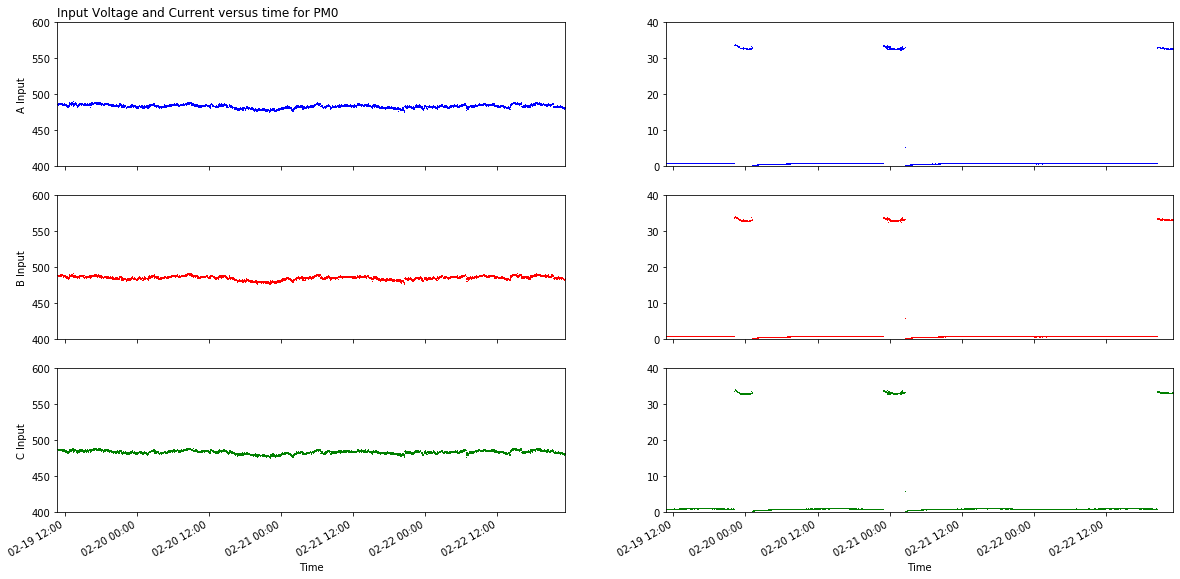

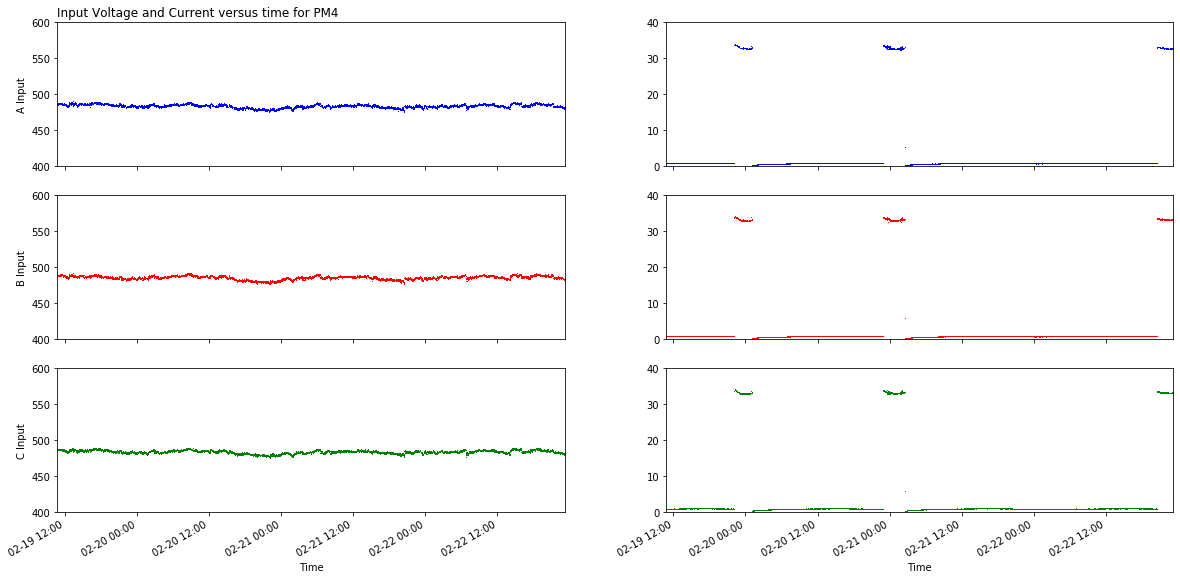

In [23]:
grapher(pm0_v_m_graph , pm0_c_m_graph, "PM0")
grapher(pm4_v_m_graph , pm4_c_m_graph, "PM4")

In [24]:
def grapher2(input, PM):
#This function is used to graph the results
#Arguments are

    plt.figure(figsize=(20,10))
    ax1 = plt.subplot(321)
    plt.title("Power Output for " + PM ,  fontdict=None, loc='left', pad=None,)
    #P Volts
    plt.plot(input[:][0], input[:][4],"b.") #Use the 0th element of each column as x and 4th element as y
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("P Volts/Amps")
    #T Volts
    ax2 = plt.subplot(323, sharex=ax1, sharey=ax1) #share x/y means they use the same axes for as previous
    plt.plot(input[:][0], input[:][6], "r.")
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel("T Volts/Amps")

    
    plt.xlim(min(input[0]), max(input[0])) #x range is between smallest and largest element of time row of matrix
    #this is because of the alphabetical import. Smallest time is earliest, largest time is latest
    plt.ylim(0,1000)                   #y range is 0 to 1000 for volts
    #can this be dynamically scaled
    plt.gcf().autofmt_xdate()         #format x axis as dates (angling)
    xfmt = mdates.DateFormatter('%m-%d %H:%M') #set the values mmm-dd 24HR time
    ax1.xaxis.set_major_formatter(xfmt) #write the format
    plt.xlabel("Time")
    
    
    ax2 = plt.subplot(322)
    #P Amps
    plt.plot(input[:][0], input[:][3],"b.") #Use the 0th element of each column as x and 1st element as y
    plt.setp(ax2.get_xticklabels(), visible=False)
    #T Amps
    ax2 = plt.subplot(324, sharex=ax2, sharey=ax2) #share x/y means they use the same axes for as previous
    plt.plot(input[:][0], input[:][5], "r.")
    plt.setp(ax2.get_xticklabels(), visible=False)

    
    #graphing params
    plt.xlim(min(input[0]), max(input[0])) #x range is between smallest and largest element of time row of matrix
    #this is because of the alphabetical import. Smallest time is earliest, largest time is latest
    plt.ylim(0,40)           #y range is 0 to 40 amps
    plt.gcf().autofmt_xdate() #format x axis as dates (angling)
    xfmt = mdates.DateFormatter('%m-%d %H:%M') #set the values mmm-dd 24HR time
    ax2.xaxis.set_major_formatter(xfmt) #write the format
    plt.xlabel("Time")
    
    #Power factor
    ax3 = plt.subplot(325)
    plt.plot(input[:][0], input [:][1], "m.")
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.ylabel("Power Factor")
    #graphing params
    plt.xlim(min(input[0]), max(input[0])) #x range is between smallest and largest element of time row of matrix
    plt.ylim(90,100)           #y range is 90 to 100 percent
    plt.gcf().autofmt_xdate() #format x axis as dates (angling)
    xfmt = mdates.DateFormatter('%m-%d %H:%M') #set the values mmm-dd 24HR time
    ax2.xaxis.set_major_formatter(xfmt) #write the format
    plt.xlabel("Time")
    name = PM + " Output"
    plt.savefig(os.path.join(path, name))
    plt.show()

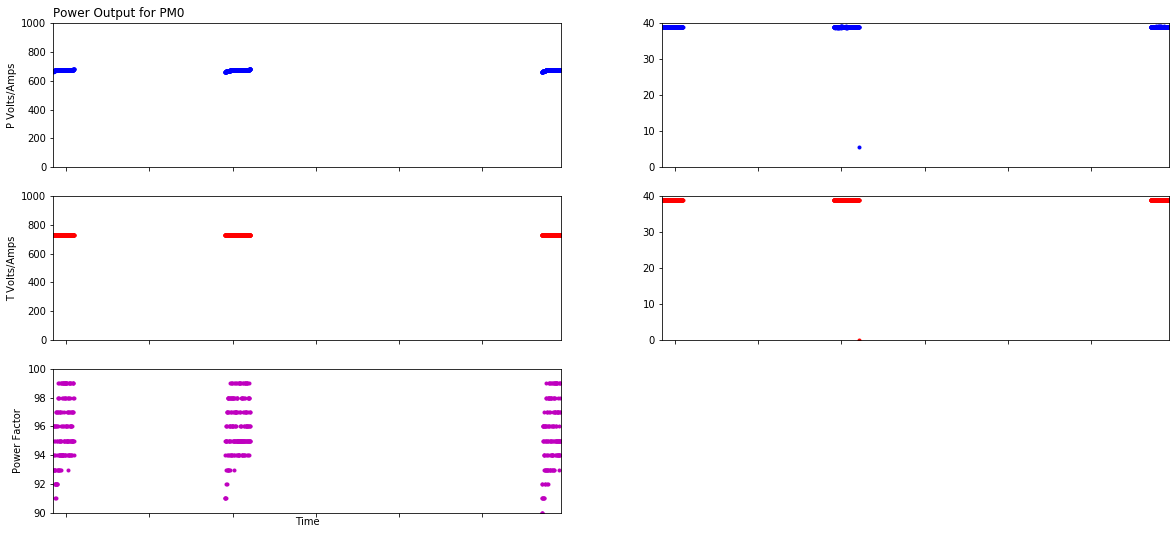

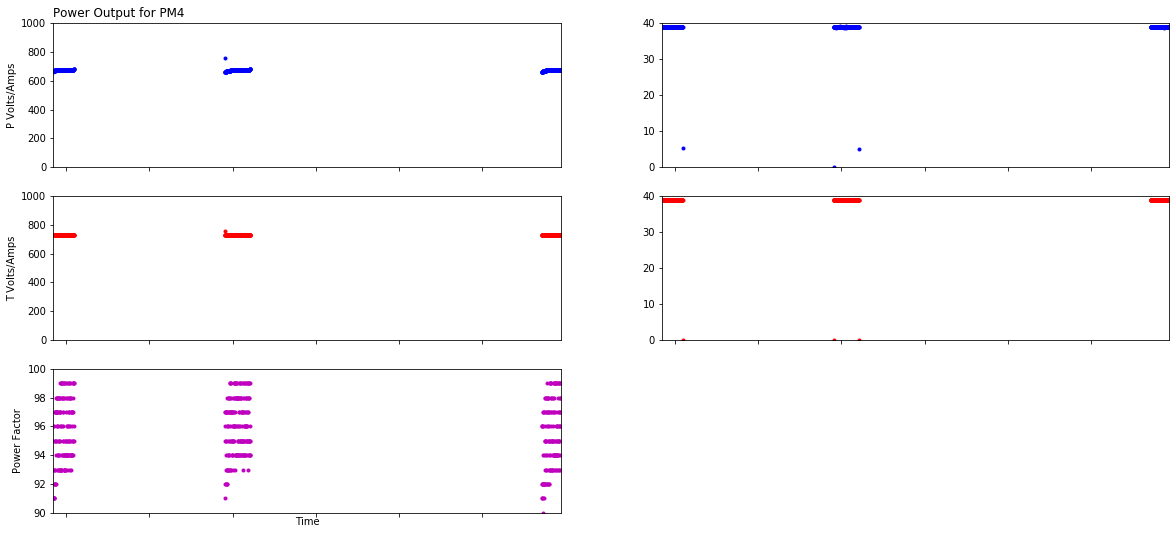

In [25]:
grapher2(pf_0_graph, "PM0")
grapher2(pf_4_graph, "PM4")

In [26]:
# time and debug check
print("Graphing complete")
toc6 = time.perf_counter()
print(round(toc6 - tic,3), "seconds")

Graphing complete
10.166 seconds


In [27]:
#find all individual fault messages and isolate them
#this is bad and slow, but will work for now

f_mess = [] #empty target matrix
for i in faults: #iterate over faults list
    for j in i:
        if j.startswith("fault"): #faults all have format "fault#=hex code" so this will reliably return them all
            f_mess.append(j)
#lists of errors & num of occur

In [28]:
#Strip faults to just hex code
fault_list = [] #empty target matrix
fault_list = re.findall(r'=(\w+)' ,  str(f_mess[:]))  #find all text with format ={alphanumeric}

In [29]:
#Use the counter function to find how many times faults occurred
f_counts = (Counter(fault_list)) #returns '{fault name': occurances} as Counter type 

In [30]:
#concantenate and print names and occurances
for i, j in f_counts.items():
    print(i , "occurred" , j , "times.")

0x00000000 occurred 30417 times.
0x0000 occurred 30417 times.


In [31]:
# time and debug check
print("Fault finding complete")
toc7= time.perf_counter()
print(round(toc7 - tic,3), "seconds")

Fault finding complete
10.271 seconds
